In [103]:
import pandas as pd
import getpass
import sqlalchemy as sa
import numpy as np
import seaborn as sns
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_selection import RFE
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

## Importing Dataset.

In [104]:
hp_df_org = pd.read_csv('Data/house_price_df.csv')
hp_df = hp_df_org

## EDA

In [105]:
hp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21597 non-null  int64  
 1   id             21597 non-null  int64  
 2   date           21597 non-null  object 
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  int64  
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  int64  
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The Dataset consists of 21597 Houses containing 21 features. Price is to be the predicted variables. 

In [106]:
hp_df.describe()

,Unnamed: 0,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,2.159700e+04
mean,10798.000000,4.580474e+09,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007547,0.234292,3.409825,...,1788.596842,291.725008,1970.999676,84.464787,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,5.402966e+05
std,6234.661218,2.876736e+09,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086549,0.766390,0.650546,...,827.759761,442.667800,29.375234,401.821438,53.513072,0.138552,0.140724,685.230472,27274.441950,3.673681e+05
min,0.000000,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,...,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,5399.000000,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,...,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,3.220000e+05
50%,10798.000000,3.904930e+09,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,...,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,4.500000e+05
75%,16197.000000,7.308900e+09,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,...,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,6.450000e+05
max,21596.000000,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,...,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


The average house has about 3 bedrooms, 2080 sqft of living area, a lot size of 15000 sqft, was built in 1970 and has a price of 540000 $. The mean and the median differ alot in the variable sqft lot, where the median is much lower then the mean. This leads to the conculusion that many houses don't have a big lot but a few house with a big lot change the distribution.

In [107]:
# sns.pairplot(hp_df) #To view remove comment. Commented to get higher performance

The Pairplot gives first interesting insides. Obviously there are linear tendencies between variables of size like lot size, size of living room. Many variables are categorical or boolean and should be transformed.

## Taking a closer look at certain variables

### Date

In [108]:
print(hp_df['date'].min(), hp_df['date'].max())

2014-05-02 2015-05-27


The date variable displays the date when the house was sold. Data is between May 2014 and May 2015. 

In [109]:
hp_df['bathrooms'].value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

Most houses have 2,5 bathrooms, a lot also only . A view outliers have a very high number of bathrooms.

## Location

For the location the datasets offers three features. Latitute and Longitude (only useful combined) and zipcodes. Let's look at both of them.

[Text(0.5, 1.0, 'Houses at waterfront')]

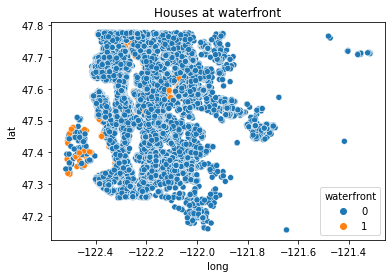

In [110]:
 sns.scatterplot(data=hp_df, x='long', y='lat', hue = 'waterfront').set(title='Houses at waterfront')

Looking at the geographical location of the houses and displaying the lot size it is visual, that the properties at the are outskirts and the countryside get bigger. 

[Text(0.5, 1.0, 'Zipcode and geographical location')]

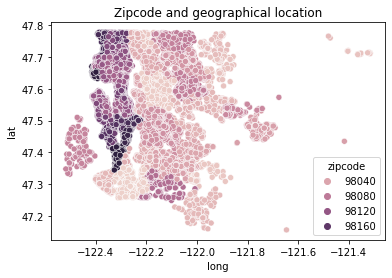

In [111]:
 sns.scatterplot(data=hp_df, x='long', y='lat', hue = 'zipcode').set(title='Zipcode and geographical location')

The zipcodes are not in a logical order so the variables should not be used as a numerical variables.
And alternative idea would be to use the travel distance from the house to the city center.

In [112]:
distance = pd.read_csv('Data/distance.csv')

In [113]:
hp_df['distanceM'] = distance['DistanceM'].astype('float64')

[Text(0.5, 1.0, 'Geographical location and distance to citycenter by car')]

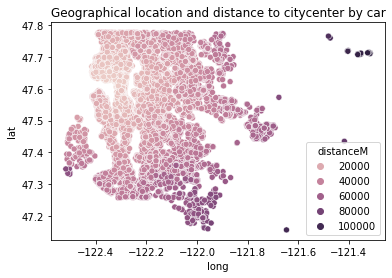

In [114]:
sns.scatterplot(data=hp_df, x='long', y='lat', hue = 'distanceM').set(title='Geographical location and distance to citycenter by car')

## Year renovated

[Text(0.5, 1.0, 'Histogram of Year renovated')]

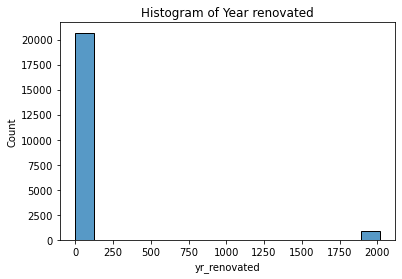

In [115]:
sns.histplot(data=hp_df, x='yr_renovated').set(title= 'Histogram of Year renovated')

The year renovated displays a 0 if the house was not yet renovated. This is not useful information in a linear regression. 

Workaround:

introduce boolean variable: Renovated: Yes/N0
Put zero values as No  


In [116]:
hp_df['renovated'] = bool

In [117]:
hp_df.loc[hp_df['yr_renovated'] == 0, 'renovated'] = False

In [118]:
hp_df.loc[hp_df['yr_renovated'] != 0, 'renovated'] = True

## Basement

<AxesSubplot:xlabel='sqft_basement', ylabel='Count'>

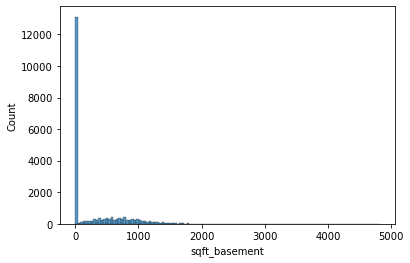

In [119]:
sns.histplot(data=hp_df, x='sqft_basement')

Most Houses don't have a basement, so a dummy will be introduced checking for basement or not:

In [120]:
hp_df.loc[hp_df['sqft_basement'] == 0, 'basement'] = False
hp_df.loc[hp_df['sqft_basement'] != 0, 'basement'] = True

## Grade

Bin grade to have a better classification:

In [121]:
grade_mean = hp_df['grade'].mean()

In [122]:
for i in range(0,len(hp_df)):
    if hp_df['grade'][i]<grade_mean:
        hp_df['grade'][i] = 'below_avg'
    else:
        hp_df['grade'][i] = 'avg_or_better'
        

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2536\79735779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hp_df['grade'][i] = 'below_avg'


<AxesSubplot:xlabel='grade', ylabel='Count'>

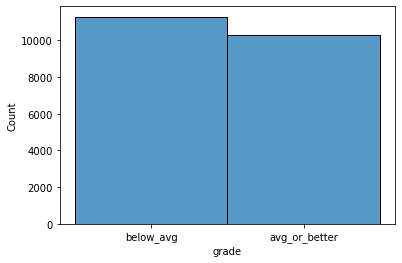

In [123]:
sns.histplot(hp_df['grade'])

## Floors

<AxesSubplot:xlabel='floors', ylabel='Count'>

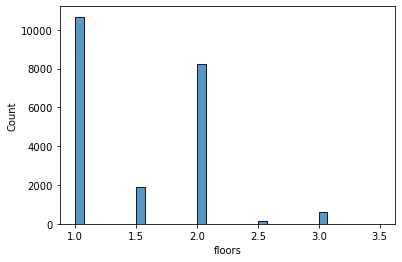

In [124]:
sns.histplot(hp_df['floors'])

In [125]:
hp_df['floors'].value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

Binning floors to 2 categories: One floor and more than one floor.

In [126]:
for i in range(0, len(hp_df)):
    if hp_df.loc[i, 'floors'] <= 1.0:
        hp_df.loc[i,'floors'] = 'one'
    else: 
        hp_df.loc[i, 'floors'] = 'more_than_one'

<AxesSubplot:xlabel='floors', ylabel='Count'>

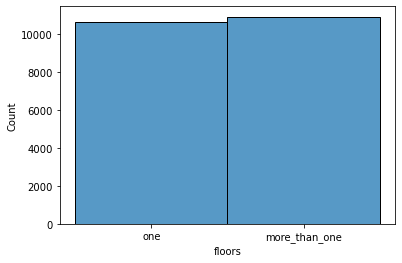

In [127]:
sns.histplot(hp_df['floors'])

## Dropping columns:

For now the columns Unnamed, id, date and long, lat will be dropped from the dataframe.

In [128]:
col_drop = ['Unnamed: 0',\
            'id',\
            'date',\
           'long',\
            'sqft_basement',\
            'yr_renovated',\
           'lat']   
# 'Unnamed: 0' : id from import without information
# 'id': random or consequtive values without values
# 'date': probably the date the house was added to the database, no additional information for houseprice
# 'lang', 'lat': Geografical data, not usable in linear regression like this, can be converted to zones using knn. 
#    Task for later. But zip codes are enough, probably


In [129]:
hp_df = hp_df.drop(col_drop, axis= 1)

## Changing datatypes


The format of the features are mostly numerical (int or float). Many of the variables have to be transformed to category to give meaningful results in a regression.
These are:

'zipcode, 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade'

In [130]:
hp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21597 non-null  int64  
 1   bathrooms      21597 non-null  float64
 2   sqft_living    21597 non-null  int64  
 3   sqft_lot       21597 non-null  int64  
 4   floors         21597 non-null  object 
 5   waterfront     21597 non-null  int64  
 6   view           21597 non-null  int64  
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  object 
 9   sqft_above     21597 non-null  int64  
 10  yr_built       21597 non-null  int64  
 11  zipcode        21597 non-null  int64  
 12  sqft_living15  21597 non-null  int64  
 13  sqft_lot15     21597 non-null  int64  
 14  price          21597 non-null  int64  
 15  distanceM      21597 non-null  float64
 16  renovated      21597 non-null  object 
 17  basement       21597 non-null  object 
dtypes: flo

In [131]:
# From the pairplot we can see which columns are categorical/dummies:
#  bderooms, bathrooms, floors, waterfront, view, condition, grade
ordinal_var = ['zipcode', 'floors', 'waterfront', 'view', 'condition', 'grade']
hp_df[ordinal_var] = hp_df[ordinal_var].astype('category')
hp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   bedrooms       21597 non-null  int64   
 1   bathrooms      21597 non-null  float64 
 2   sqft_living    21597 non-null  int64   
 3   sqft_lot       21597 non-null  int64   
 4   floors         21597 non-null  category
 5   waterfront     21597 non-null  category
 6   view           21597 non-null  category
 7   condition      21597 non-null  category
 8   grade          21597 non-null  category
 9   sqft_above     21597 non-null  int64   
 10  yr_built       21597 non-null  int64   
 11  zipcode        21597 non-null  category
 12  sqft_living15  21597 non-null  int64   
 13  sqft_lot15     21597 non-null  int64   
 14  price          21597 non-null  int64   
 15  distanceM      21597 non-null  float64 
 16  renovated      21597 non-null  object  
 17  basement       21597 non-null  

In [132]:
hp_df.shape

(21597, 18)

## Checking correlation of numerical variables

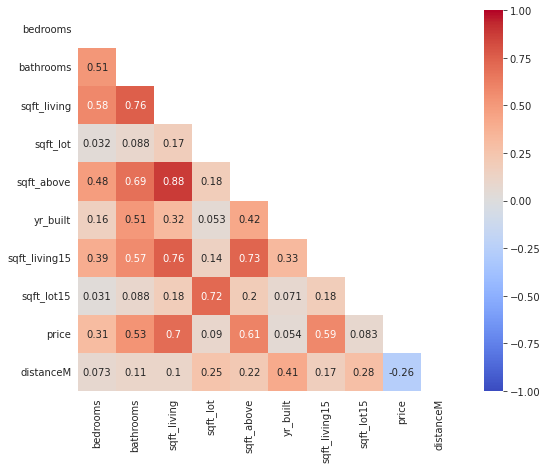

In [133]:
corr = hp_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

The features should not be correlated in order to fulfill the asumtions of linear regression.
As expected there is a lot of correlation between sqf_above, sqf_living and other measures of size. 
- First: Drop sqf_above

In [134]:
corr_matrix=hp_df.corr().abs()
upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
corr_var = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.80)]
hp_df = hp_df.drop(corr_var, axis= 1)
hp_df.shape

(21597, 17)

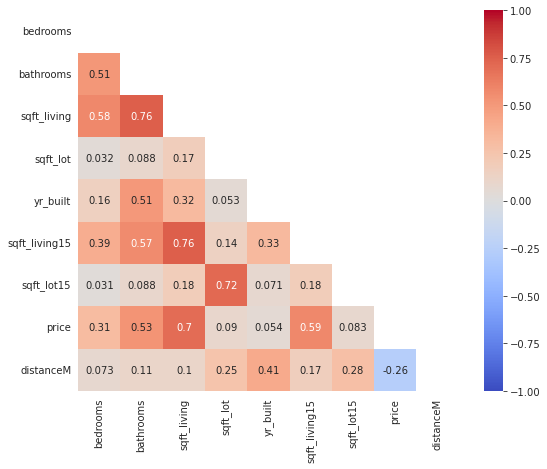

In [135]:
corr = hp_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

The new dataframe does not contain anymore variables with a higher correlation than 0.8, but some variable still have high correlation which could be analysed later.

# Normalization

## Histograms
To check for the assumtion of normal distributions we check the histograms of the numerical variables

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>],
       [<AxesSubplot:title={'center':'sqft_lot15'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'distanceM'}>]], dtype=object)

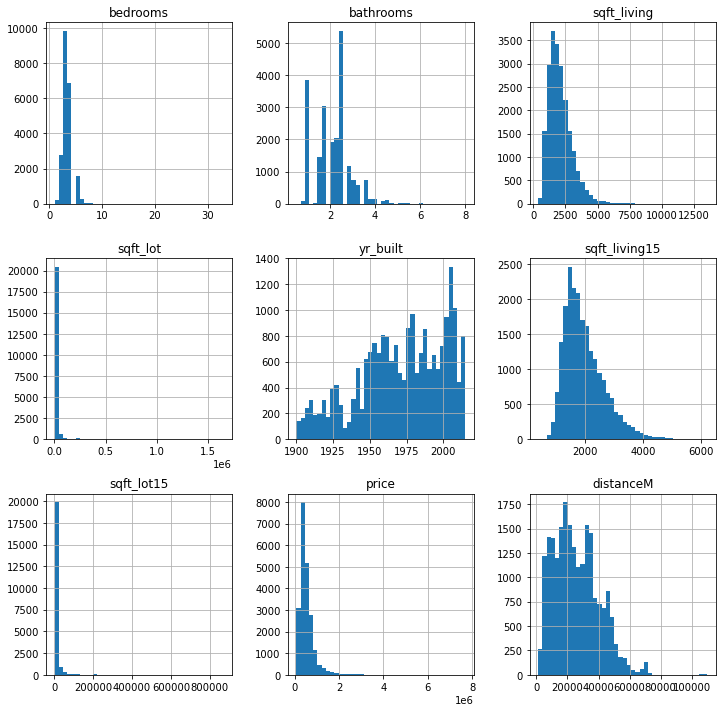

In [136]:
hp_df.select_dtypes(['int64','float']).hist(figsize=(12,12), bins=40)


All numerical varibales are non-normaly distributed and need to be transformed. 

## Transforming to normal distribution

In [137]:
hp_df.select_dtypes(['int64','float']).columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built',
       'sqft_living15', 'sqft_lot15', 'price', 'distanceM'],
      dtype='object')

In [138]:
# List of variables names to be transformed: 
to_trans =  {'sqft_living': 'qt',\
             'sqft_lot': 'qt',\
             'yr_built': 'qt',\
             'sqft_living15': 'qt',\
             'sqft_lot15': 'qt',\
            'bedrooms': 'qt',\
            'bathrooms': 'qt',\
            'distanceM': 'qt'}

For the transformation of the variables the Quantile Transformer is applied. 

In [139]:

pt = PowerTransformer()
qt = QuantileTransformer(output_distribution="normal")

transformed_cols = []
for i in to_trans.keys():
    if list(to_trans.values())[0] == 'pt':
        transformed = pt.fit_transform(hp_df[i].to_numpy().reshape(-1,1))
    elif list(to_trans.values())[0] == 'qt':
        transformed = qt.fit_transform(hp_df[i].to_numpy().reshape(-1,1))
    else: 
        print('no transformer could be identified')
    col_name = i+'_transformed'
    #sns.displot(transformed).set(title=f'Histogram of {col_name}')
    hp_df[col_name] = transformed
    transformed_cols = transformed_cols + [col_name]
    hp_df = hp_df.drop(i, axis= 1)
    
    
hp_df.describe()

,price,sqft_living_transformed,sqft_lot_transformed,yr_built_transformed,sqft_living15_transformed,sqft_lot15_transformed,bedrooms_transformed,bathrooms_transformed,distanceM_transformed
count,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,0.000009,-0.000043,-0.007133,0.000007,-0.000060,-0.015954,0.014393,0.000292
std,3.673681e+05,0.999686,0.999566,1.046026,0.999868,1.000081,1.003797,0.950943,1.001638
min,7.800000e+04,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,3.220000e+05,-0.667419,-0.676854,-0.689529,-0.665852,-0.673702,-0.346817,-0.469603,-0.674452
50%,4.500000e+05,-0.003764,0.000418,0.003764,0.001255,0.000000,-0.346817,0.067799,-0.000254
75%,6.450000e+05,0.675277,0.674710,0.681594,0.670557,0.674476,0.678433,0.520661,0.674567
max,7.700000e+06,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338


In [140]:
transformed_cols

['sqft_living_transformed',
 'sqft_lot_transformed',
 'yr_built_transformed',
 'sqft_living15_transformed',
 'sqft_lot15_transformed',
 'bedrooms_transformed',
 'bathrooms_transformed',
 'distanceM_transformed']

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'sqft_living_transformed'}>,
        <AxesSubplot:title={'center':'sqft_lot_transformed'}>],
       [<AxesSubplot:title={'center':'yr_built_transformed'}>,
        <AxesSubplot:title={'center':'sqft_living15_transformed'}>,
        <AxesSubplot:title={'center':'sqft_lot15_transformed'}>],
       [<AxesSubplot:title={'center':'bedrooms_transformed'}>,
        <AxesSubplot:title={'center':'bathrooms_transformed'}>,
        <AxesSubplot:title={'center':'distanceM_transformed'}>]],
      dtype=object)

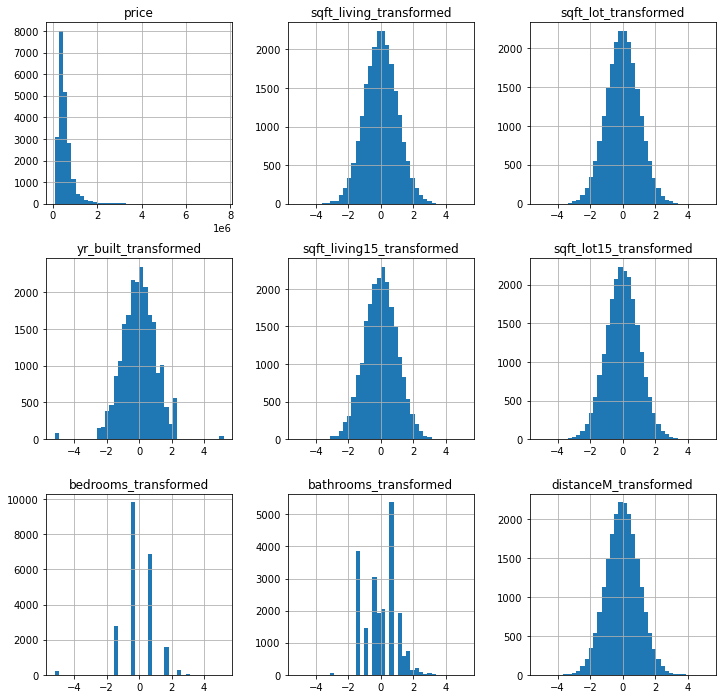

In [141]:
hp_df.select_dtypes(['int', 'float64']).hist(figsize=(12,12), bins=40)

## Remove outliers

The Datasets contains a few datapoints that can described as outliers. One house for example as 33 rooms while the average amount of rooms is around 3. Using the two time the Interquartile range whe remove the outliers. 

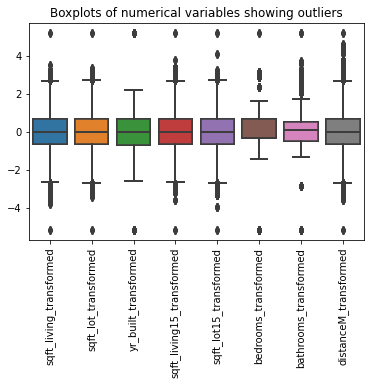

In [142]:
for i in transformed_cols:
    sns.boxplot(data=hp_df[transformed_cols]).set(title='Boxplots of numerical variables showing outliers')
    plt.xticks(rotation=90)

In [143]:
 len_before = hp_df.shape[0]

In [144]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-2*iqr
    fence_high = q3+2*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

for i in transformed_cols: 
    hp_df = remove_outlier(hp_df, i )

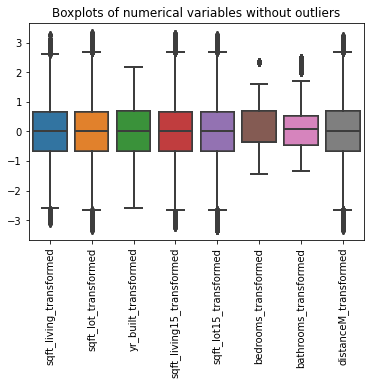

In [145]:
for i in transformed_cols:
    sns.boxplot(data=hp_df[transformed_cols]).set(title='Boxplots of numerical variables without outliers')
    plt.xticks(rotation=90)

In [146]:
len_after = hp_df.shape[0]

In [147]:
print(f'Of the original dataset {round(len_after/len_before * 100, 2)}% of rows remain')

Of the original dataset 97.49% of rows remain


## One-hot encode categorical variables

In [148]:
col_names_object = list(hp_df.select_dtypes("object").columns)
col_names_object.extend(hp_df.select_dtypes("category").columns)
col_names_object

['renovated',
 'basement',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'zipcode']

In [149]:
cat_features =  pd.get_dummies(hp_df[col_names_object] , drop_first=True)

In [150]:
hp_df = hp_df.drop(col_names_object, axis = 1)

In [151]:
hp_df[cat_features.columns] = cat_features

In [152]:
list(hp_df.columns)

['price',
 'sqft_living_transformed',
 'sqft_lot_transformed',
 'yr_built_transformed',
 'sqft_living15_transformed',
 'sqft_lot15_transformed',
 'bedrooms_transformed',
 'bathrooms_transformed',
 'distanceM_transformed',
 'renovated_True',
 'basement_True',
 'floors_one',
 'waterfront_1',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_below_avg',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98058',
 'zip

## Linear Regression

We're splitting into X and y (predictors and target variable).


In [153]:
def Xy_split(df, output_col):
    """ Split the dataset into:
        X = dataframe of input variables
        y = predicted variable
    """
    X=df.drop(output_col, axis=1)
    y=df[output_col]
    return X, y

X,y = Xy_split(hp_df, 'price') 

We're creating train and test-sets.

In [154]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=100)

We're scaling the data using Standard Scaler.

In [155]:
std_scaler=StandardScaler().fit(X_train.select_dtypes(['int', 'float64']))
X_train_scaled=std_scaler.transform(X_train.select_dtypes(['int', 'float64']))
X_test_scaled=std_scaler.transform(X_test.select_dtypes(['int', 'float64']))

In [156]:
X_train.describe()

,sqft_living_transformed,sqft_lot_transformed,yr_built_transformed,sqft_living15_transformed,sqft_lot15_transformed,bedrooms_transformed,bathrooms_transformed,distanceM_transformed,renovated_True,basement_True,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
count,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,...,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000,14737.000000
mean,0.011386,-0.003241,0.014062,0.003504,-0.004450,0.021802,0.016956,-0.003994,0.040239,0.394721,...,0.013300,0.003054,0.022664,0.012350,0.011468,0.011468,0.012553,0.006786,0.013368,0.015539
std,0.966032,0.987419,0.964327,0.990221,0.987897,0.857398,0.913158,0.985490,0.196526,0.488807,...,0.114559,0.055176,0.148835,0.110445,0.106475,0.106475,0.111340,0.082098,0.114847,0.123688
min,-3.109054,-3.339751,-2.575483,-3.221682,-3.343812,-1.453280,-1.324958,-3.316775,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.647177,-0.664287,-0.656486,-0.665852,-0.666792,-0.346817,-0.469603,-0.660977,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.007527,0.001255,0.003764,0.001255,0.011291,-0.346817,0.067799,-0.006196,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.675277,0.658043,0.681594,0.670557,0.657264,0.678433,0.520661,0.655720,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.091406,3.290546,2.183092,3.285246,3.265123,2.365248,2.483413,3.110571,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We're concatenating the data scaled numerical data with the categorical variables.

In [157]:
X_train_scaled = np.concatenate((X_train_scaled, np.asarray(X_train[list(cat_features.columns)])), axis = 1) 

X_test_scaled = np.concatenate((X_test_scaled, np.asarray(X_test[list(cat_features.columns)])), axis =1)
print(X_train_scaled.shape, X_test_scaled.shape)

(14737, 90) (6317, 90)


We're modeling using linear regression and desplaying key indicators to interpret the model fit.

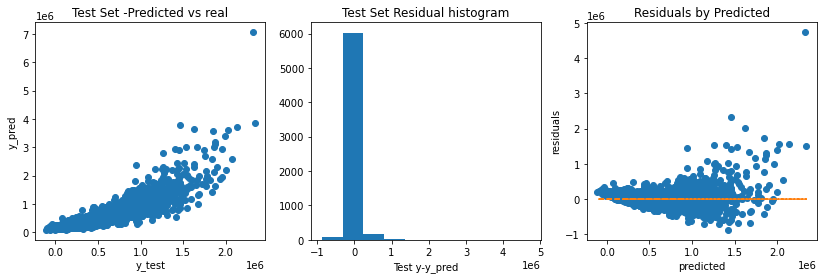

In [158]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train) 


y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)


result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

The scatterplot of the target variable and the predicted variables displays a obvious linear trend. Risiduals seem to be normaly distributed. The Residual are not perfectly randomly distributed around 0, but overall the model seems to be okay. 

In [159]:
print('MSE test: ',  round(mse(y_test,y_pred),2))
print('MSE train: ', round(mse(y_train,y_pred_train),2))
print('RMSE test: ', round(np.sqrt(mae(y_test,y_pred)),2))
print('MSE train - MSE test: ', round(mse(y_train,y_pred_train) - mse(y_test,y_pred),2) )

print('MAE test: ', round(mae(y_test,y_pred),2))

R2_test=model.score(X_test_scaled,y_test)
R2_train=model.score(X_train_scaled,y_train)
print('R2_test: ', round(R2_test, 2))
print('R2_train: ', round(R2_train, 2))

Adj_R2= 1 - (1-R2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('Adj_R2:', round(Adj_R2,2))

MSE test:  28709811841.65
MSE train:  25965691299.75
RMSE test:  312.71
MSE train - MSE test:  -2744120541.89
MAE test:  97790.59
R2_test:  0.76
R2_train:  0.77
Adj_R2: 0.75


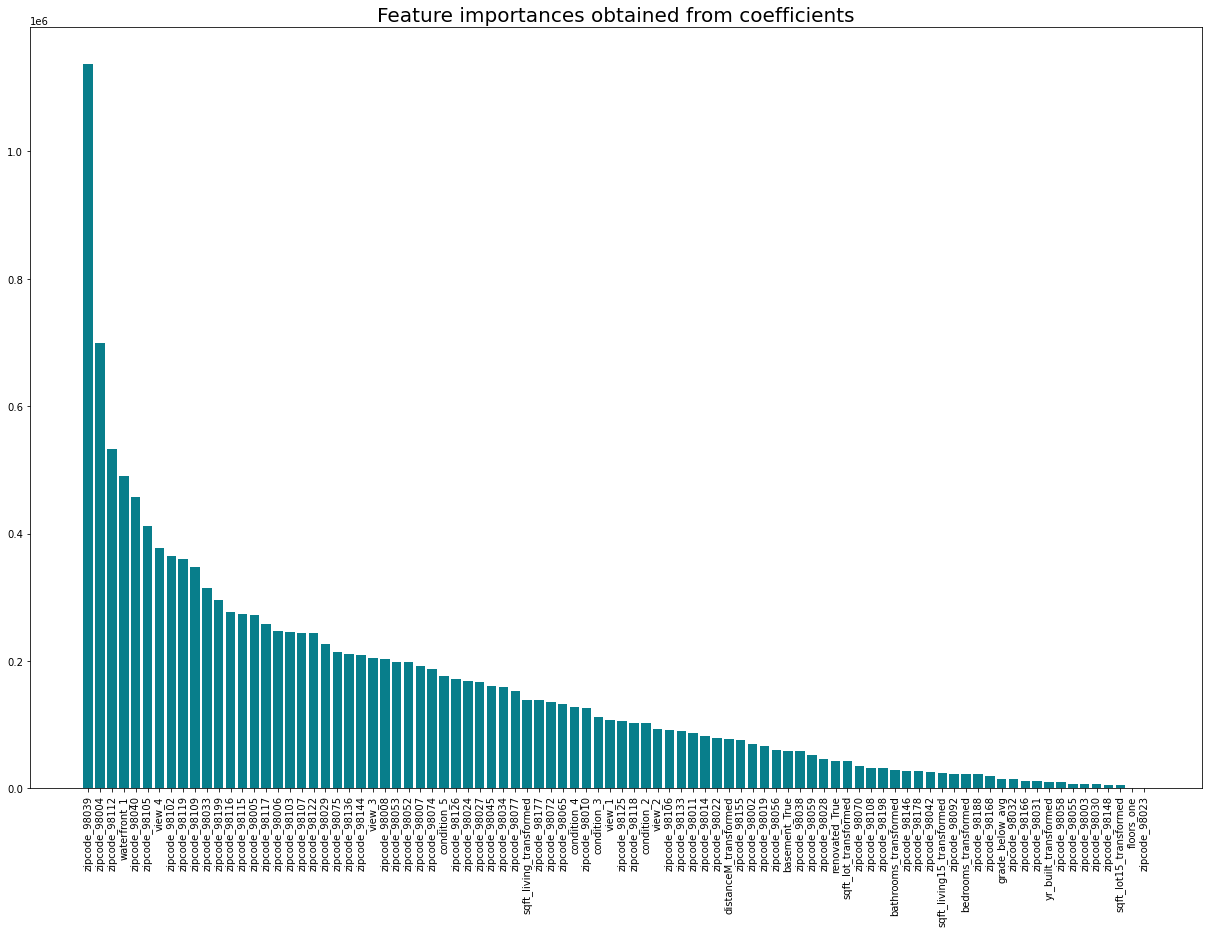

<Figure size 1440x3600 with 0 Axes>

In [160]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances
plt.figure(figsize=(21,14))
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.figure(figsize=(20,50))
plt.show()

In [163]:
features_importances.nlargest(10, 'Importance')
features_imp_first_model = features_importances

The Top 10 most important features are mostly zipcodes. Also waterfront and view play an important role.

## Get P-values from model 

To filter the significant columns we get the p-value from the linear regression. If it is higher than 0.5 the column is dropped.

In [164]:
X_train_const_scaled = sm.add_constant(X_train_scaled) #getting model using sm.Ols (more detailed statistics)
model = sm.OLS(y_train, X_train_const_scaled).fit()

In [165]:
sign_cols = model.pvalues[1:len(model.pvalues)]  # remove constant
sign_cols = pd.DataFrame([sign_cols])


In [166]:
X_col_list = X.columns
X_dropped_p = X
for i in range(0,len(X.columns)):
    if sign_cols.iloc[0,i]>0.05:
        X_dropped_p = X_dropped_p.drop(X_col_list[i], axis=1)

In [167]:
print(f'From orginally {X.shape[1]} features {X_dropped_p.shape[1]} features remain.')

From orginally 90 features 72 features remain.


## 3d linear Model only including variabels that had a siginificant p-value in the 2s Model

In [168]:
X_train, X_test, y_train, y_test=train_test_split(X_dropped_p, y, test_size=.30,random_state=100)

In [169]:
X_train_num = X_train.select_dtypes(['float64'])
X_test_num = X_test.select_dtypes(['float64'])
X_train_cat = X_train.select_dtypes(['uint8'])
X_test_cat = X_test.select_dtypes(['uint8'])
print(X_train_num.shape, X_test_num.shape, X_train_cat.shape, X_test_cat.shape)

(14737, 7) (6317, 7) (14737, 65) (6317, 65)


In [170]:
std_scaler=StandardScaler().fit(X_train_num)   ##. finding the parameters ( mean, variance from the training set )
                                            ## 
X_train_scaled=std_scaler.transform(X_train_num)

X_test_scaled=std_scaler.transform(X_test_num)
X_test_scaled.shape

(6317, 7)

In [171]:
X_train_scaled = np.concatenate((X_train_scaled, np.asarray(X_train_cat)), axis = 1) 

X_test_scaled = np.concatenate((X_test_scaled, np.asarray(X_test_cat)), axis =1)
print(X_train_scaled.shape, X_test_scaled.shape)

(14737, 72) (6317, 72)


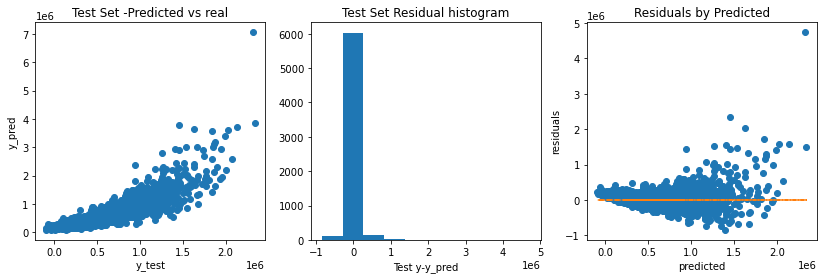

In [172]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train) 


y_pred=model.predict(X_test_scaled)   # model prediction
y_pred_train=model.predict(X_train_scaled)


result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

In [173]:
print('MSE test: ',  round(mse(y_test,y_pred),2))
print('MSE train: ', round(mse(y_train,y_pred_train),2))
print('RMSE test: ', round(np.sqrt(mae(y_test,y_pred)),2))
print('MSE train - MSE test: ', round(mse(y_train,y_pred_train) - mse(y_test,y_pred),2) )

print('MAE test: ', round(mae(y_test,y_pred),2))

R2_test=model.score(X_test_scaled,y_test)
R2_train=model.score(X_train_scaled,y_train)
print('R2_test: ', round(R2_test, 2))
print('R2_train: ', round(R2_train, 2))

Adj_R2= 1 - (1-R2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print('Adj_R2:', round(Adj_R2,2))

MSE test:  28781328700.84
MSE train:  26023987438.71
RMSE test:  312.9
MSE train - MSE test:  -2757341262.13
MAE test:  97905.27
R2_test:  0.76
R2_train:  0.77
Adj_R2: 0.75


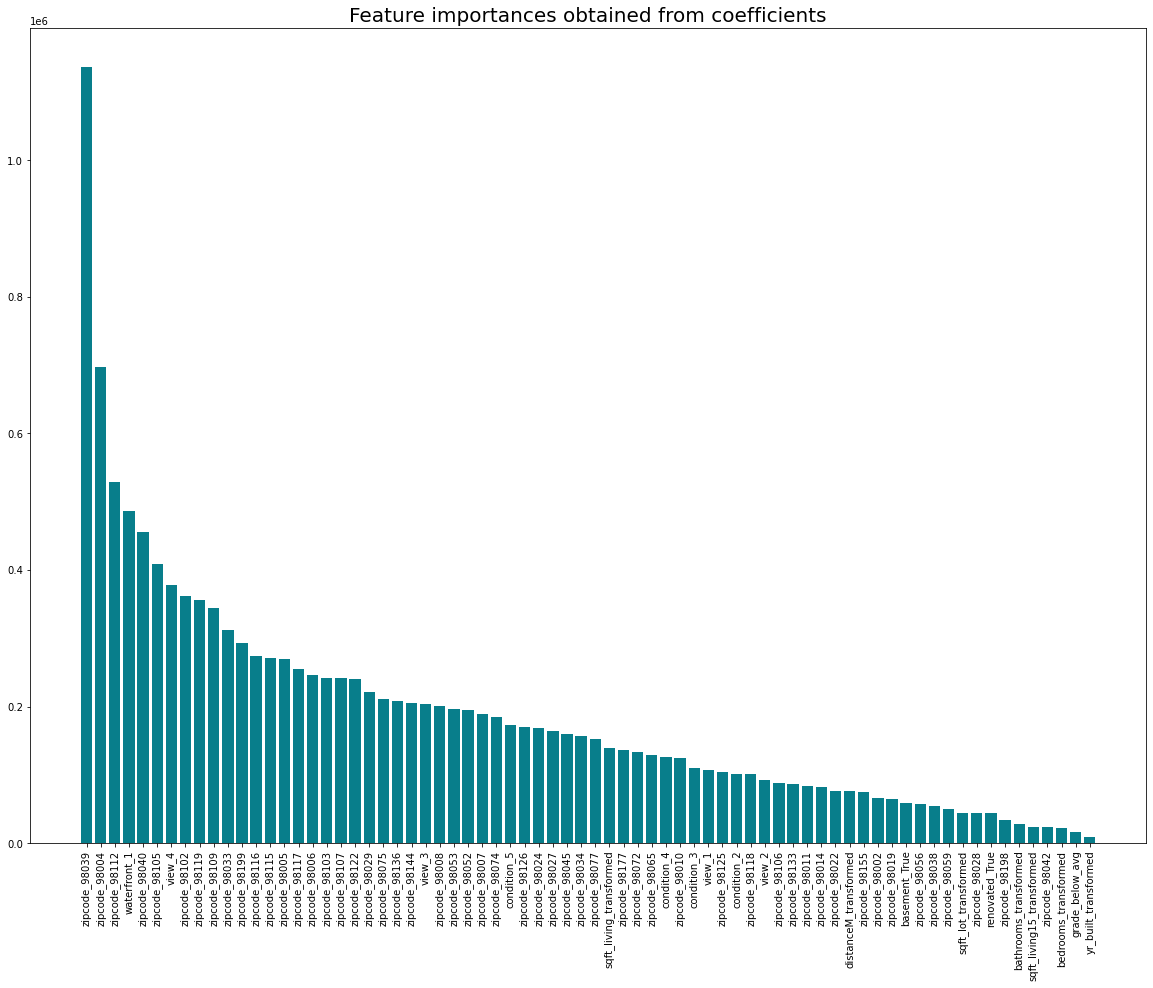

In [174]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)
features_importances
plt.figure(figsize=(20, 15))
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [175]:
features_importances.nlargest(10, 'Importance')


,Attribute,Importance
37,zipcode_98039,1.136976e+06
20,zipcode_98004,6.975250e+05
56,zipcode_98112,5.292650e+05
9,waterfront_1,4.862196e+05
38,zipcode_98040,4.555987e+05
52,zipcode_98105,4.084745e+05
13,view_4,3.782456e+05
50,zipcode_98102,3.618689e+05
61,zipcode_98119,3.569081e+05
55,zipcode_98109,3.449333e+05


In [176]:
#features_importances.to_csv('Data/final_model_feature_importance.csv')

In [177]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     680.5
Date:                Thu, 21 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:36:12   Log-Likelihood:            -1.9762e+05
No. Observations:               14737   AIC:                         3.954e+05
Df Residuals:                   14664   BIC:                         3.959e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.769e+05   3.75e+04      7.381      0.0

## Visualizing results:

Zip-code showed to be very determining for prices. The zipcode 98039 showed to show the highest price effect.

In [178]:
features_imp_first_model

,Attribute,Importance
44,zipcode_98039,1.137882e+06
23,zipcode_98004,6.988572e+05
68,zipcode_98112,5.322568e+05
11,waterfront_1,4.905169e+05
45,zipcode_98040,4.568538e+05
...,...,...
38,zipcode_98030,6.647886e+03
81,zipcode_98148,5.865926e+03
4,sqft_lot15_transformed,4.584630e+03
10,floors_one,8.767546e+02


(array([47., 23., 10.,  5.,  3.,  0.,  1.,  0.,  0.,  1.]),
 array([8.05879922e+02, 1.14513449e+05, 2.28221018e+05, 3.41928587e+05,
        4.55636156e+05, 5.69343725e+05, 6.83051294e+05, 7.96758863e+05,
        9.10466432e+05, 1.02417400e+06, 1.13788157e+06]),
 <BarContainer object of 10 artists>)

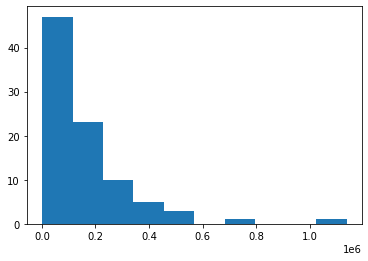

In [179]:
plt.hist(features_imp_first_model['Importance'])

In [180]:
features_imp_first_model['zip_rank'] = pd.qcut(features_imp_first_model['Importance'], q=4, labels=["low", "medium", "high", "premium"])

rank into Quartiles

Get only zipcodes to compare:

In [181]:
importance_zipcode = features_imp_first_model[features_imp_first_model['Attribute'].str.startswith('zipcode')]

In [182]:
importance_zipcode['zipcode']=importance_zipcode['Attribute'].str.replace('zipcode_', '')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2536\3603182415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importance_zipcode['zipcode']=importance_zipcode['Attribute'].str.replace('zipcode_', '')


In [183]:
importance_zipcode['zipcode'] =importance_zipcode['zipcode'].astype('int')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2536\1649944960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importance_zipcode['zipcode'] =importance_zipcode['zipcode'].astype('int')


In [184]:
hp_df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21597 non-null  int64  
 1   id             21597 non-null  int64  
 2   date           21597 non-null  object 
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  object 
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  int64  
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  int64  
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [185]:
importance_zipcode.shape, hp_df_org.shape

((69, 4), (21597, 25))

In [186]:
df_result = pd.merge(importance_zipcode[['zipcode', 'zip_rank']], hp_df_org, on='zipcode' )

In [187]:
df_result.shape

(21236, 26)

In [188]:
df_result['zip_rank'].sort_values()

21235        low
18177        low
18176        low
18175        low
18174        low
          ...   
4355     premium
4356     premium
4357     premium
4347     premium
0        premium
Name: zip_rank, Length: 21236, dtype: category
Categories (4, object): ['low' < 'medium' < 'high' < 'premium']

[Text(0.5, 1.0, 'Zipcodes ordered by importance')]

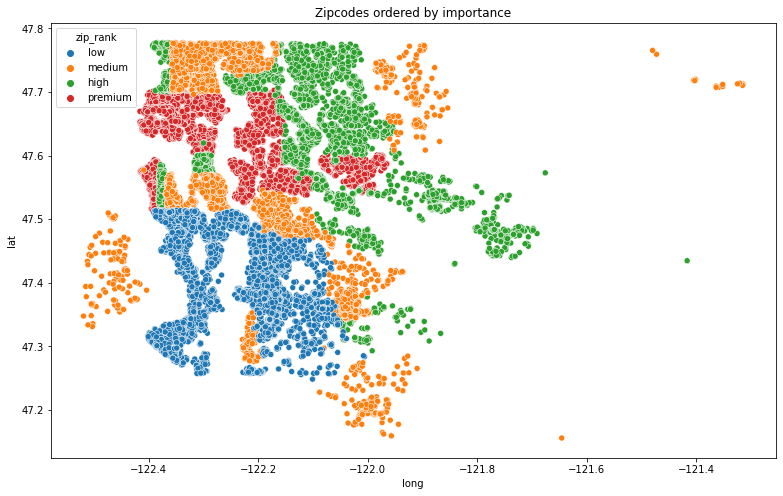

In [189]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=df_result, x='long', y='lat', hue='zip_rank').set(title= 'Zipcodes ordered by importance')

In [190]:
df_result.shape

(21236, 26)

Run model again with rated zipcodes to get more precise results.

In [191]:
hp_df_org['price_rank'] = pd.qcut(hp_df_org['price'], q=4, labels=["low", "medium", "high", "premium"])

[Text(0.5, 1.0, 'Prices ordered geographically')]

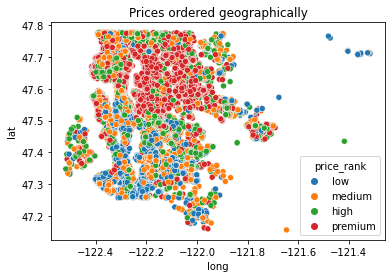

In [192]:
sns.scatterplot(data=hp_df_org, x='long', y='lat', hue='price_rank').set(title= 'Prices ordered geographically')

In [193]:
avg_price_zip = hp_df_org[['zipcode', 'price']].groupby('zipcode').mean('price')
avg_price_zip['avg_price_zip']=avg_price_zip['price']
avg_price_zip.drop('price', axis=1, inplace=True)
avg_price_zip

,avg_price_zip
zipcode,
98001,2.811949e+05
98002,2.342840e+05
98003,2.941113e+05
98004,1.356524e+06
98005,8.102897e+05
...,...
98177,6.764194e+05
98178,3.106128e+05
98188,2.890783e+05


In [194]:
merged_av_price = pd.merge(avg_price_zip[['avg_price_zip']], hp_df_org, on='zipcode')
merged_av_price['price_ranked_zip'] = pd.qcut(merged_av_price['avg_price_zip'], q=4, labels=["low", "medium", "high", "premium"])
merged_av_price.info()
merged_av_price['price_ranked_zip']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   zipcode           21597 non-null  int64   
 1   avg_price_zip     21597 non-null  float64 
 2   Unnamed: 0        21597 non-null  int64   
 3   id                21597 non-null  int64   
 4   date              21597 non-null  object  
 5   bedrooms          21597 non-null  int64   
 6   bathrooms         21597 non-null  float64 
 7   sqft_living       21597 non-null  int64   
 8   sqft_lot          21597 non-null  int64   
 9   floors            21597 non-null  object  
 10  waterfront        21597 non-null  int64   
 11  view              21597 non-null  int64   
 12  condition         21597 non-null  int64   
 13  grade             21597 non-null  object  
 14  sqft_above        21597 non-null  int64   
 15  sqft_basement     21597 non-null  int64   
 16  yr_built          2159

0            low
1            low
2            low
3            low
4            low
          ...   
21592    premium
21593    premium
21594    premium
21595    premium
21596    premium
Name: price_ranked_zip, Length: 21597, dtype: category
Categories (4, object): ['low' < 'medium' < 'high' < 'premium']

[Text(0.5, 1.0, 'Average prices per zipcode ranked')]

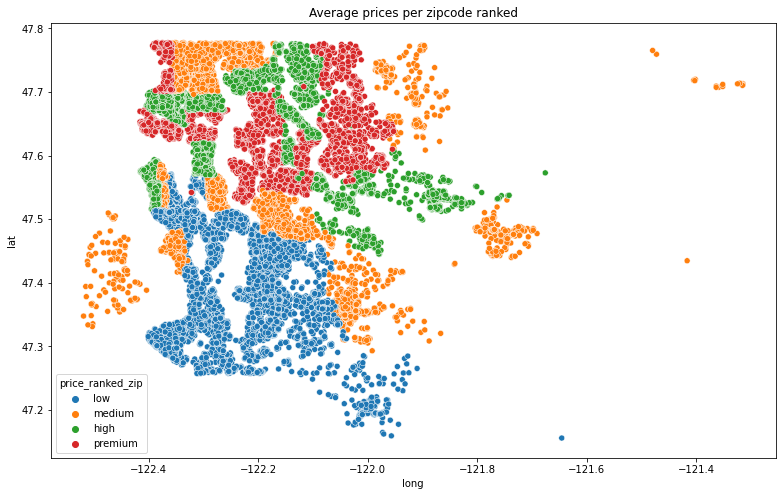

In [195]:
plt.figure(figsize=(13,8))
sns.scatterplot(data=merged_av_price, x='long', y='lat', hue='price_ranked_zip').set(title='Average prices per zipcode ranked')

<AxesSubplot:xlabel='long', ylabel='lat'>

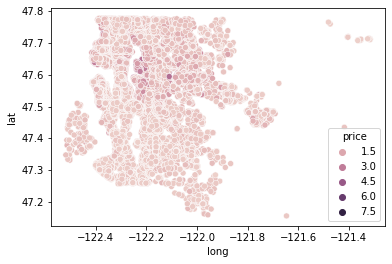

In [196]:
sns.scatterplot(data=merged_av_price, x='long', y='lat', hue='price')

<AxesSubplot:xlabel='long', ylabel='lat'>

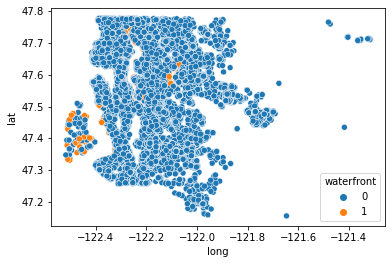

In [197]:
sns.scatterplot(data = hp_df_org, x='long', y='lat', hue='waterfront')

<AxesSubplot:xlabel='long', ylabel='lat'>

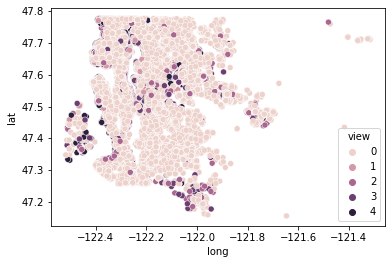

In [198]:
sns.scatterplot(data = hp_df_org, x='long', y='lat', hue='view')